Gen 000 | Best Fitness: 203.1
Gen 001 | Best Fitness: 205.7
Gen 002 | Best Fitness: 205.7
Gen 003 | Best Fitness: 205.7
Gen 004 | Best Fitness: 205.7
Gen 005 | Best Fitness: 208.3
Gen 006 | Best Fitness: 208.3
Gen 007 | Best Fitness: 208.3
Gen 008 | Best Fitness: 208.3
Gen 009 | Best Fitness: 208.3
Gen 010 | Best Fitness: 208.3
Gen 011 | Best Fitness: 208.3
Gen 012 | Best Fitness: 208.3
Gen 013 | Best Fitness: 208.3
Gen 014 | Best Fitness: 223.4
Gen 015 | Best Fitness: 223.4
Gen 016 | Best Fitness: 223.4
Gen 017 | Best Fitness: 223.4
Gen 018 | Best Fitness: 223.4
Gen 019 | Best Fitness: 223.4
Gen 020 | Best Fitness: 223.4
Gen 021 | Best Fitness: 223.4
Gen 022 | Best Fitness: 223.4
Gen 023 | Best Fitness: 223.4
Gen 024 | Best Fitness: 223.4
Gen 025 | Best Fitness: 223.4
Gen 026 | Best Fitness: 223.4
Gen 027 | Best Fitness: 223.4
Gen 028 | Best Fitness: 223.4
Gen 029 | Best Fitness: 223.4
Gen 030 | Best Fitness: 223.4
Gen 031 | Best Fitness: 223.4
Gen 032 | Best Fitness: 223.4
Gen 033 | 

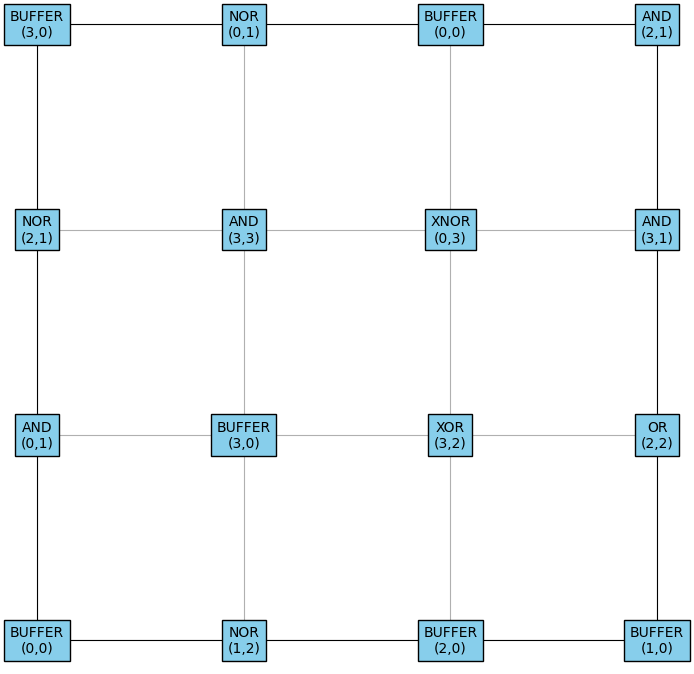


Verification:
Input 00 ([0, 0, 0, 0]) => Output [0, 0, 0, 1] ✅
Input 01 ([0, 0, 0, 1]) => Output [0, 0, 0, 1] ✅
Input 02 ([0, 0, 1, 0]) => Output [1, 0, 1, 1] ✅
Input 03 ([0, 0, 1, 1]) => Output [0, 0, 1, 0] ✅
Input 04 ([0, 1, 0, 0]) => Output [1, 0, 1, 1] ❌
Input 05 ([0, 1, 0, 1]) => Output [0, 0, 1, 0] ❌
Input 06 ([0, 1, 1, 0]) => Output [1, 0, 1, 1] ✅
Input 07 ([0, 1, 1, 1]) => Output [0, 0, 1, 0] ✅
Input 08 ([1, 0, 0, 0]) => Output [1, 1, 1, 1] ✅
Input 09 ([1, 0, 0, 1]) => Output [1, 1, 1, 1] ✅
Input 10 ([1, 0, 1, 0]) => Output [0, 1, 0, 1] ✅
Input 11 ([1, 0, 1, 1]) => Output [0, 0, 0, 0] ✅
Input 12 ([1, 1, 0, 0]) => Output [0, 0, 1, 0] ✅
Input 13 ([1, 1, 0, 1]) => Output [1, 1, 1, 1] ✅
Input 14 ([1, 1, 1, 0]) => Output [0, 0, 1, 0] ✅
Input 15 ([1, 1, 1, 1]) => Output [1, 1, 1, 1] ✅


In [8]:
"""
Genetic Algorithm for Evolving Logic Circuits
--------------------------------------------
This program evolves a 4x4 grid of logic gates to produce desired outputs
for all 16 possible 4-bit input combinations.
"""

import numpy as np
import matplotlib.pyplot as plt
import random

# ======================
# LOGIC GATE DEFINITIONS
# ======================

# Define all gate operations (a and b are binary inputs)
def AND(a, b): return a & b      # Logical AND
def OR(a, b): return a | b       # Logical OR
def XOR(a, b): return a ^ b      # Exclusive OR
def NOT(a, _): return 1 - a      # Inverter (ignores second input)
def NOR(a, b): return 1 - (a | b) # NOT OR
def XNOR(a, b): return 1 - (a ^ b) # NOT XOR (equivalence)
def BUFFER(a, _): return a       # Pass-through gate (ignores second input)

# Dictionary mapping gate names to their functions
GATE_FUNCS = {
    'AND': AND,
    'OR': OR,
    'XOR': XOR,
    'NOT': NOT,
    'NOR': NOR,
    'XNOR': XNOR,
    'BUFFER': BUFFER
}

# Hardware cost for each gate type (used in fitness calculation)
GATE_COST = {
    'AND': 1,    # Basic gate
    'OR': 1,      # Basic gate
    'XOR': 2,     # More complex
    'NOT': 0.5,   # Simple inverter
    'NOR': 1.5,   # Slightly more complex
    'XNOR': 2.5,  # Most complex
    'BUFFER': 0.3 # Minimal cost
}

# List of available gate types
GATE_LIST = list(GATE_FUNCS.keys())

# ========================
# CHROMOSOME CONFIGURATION
# ========================

# Each gate is encoded with:
# - 3 bits for gate type (7 possible gates)
# - 2 bits for input 1 selection
# - 2 bits for input 2 selection
BITS_PER_GATE = 7
GRID_SIZE = 4  # 4x4 grid of gates
CHROMOSOME_LENGTH = GRID_SIZE * GRID_SIZE * BITS_PER_GATE  # Total bits per individual

DESIRED_OUTPUT = [
    [0, 1, 1, 0],
    [0, 1, 1, 0],
    [1, 1, 1, 0],
    [0, 1, 1, 0],
    [0, 0, 0, 0],
    [1, 1, 1, 0],
    [1, 1, 1, 0],
    [0, 1, 0, 0],
    [1, 1, 1, 0],
    [1, 1, 1, 0],
    [0, 1, 1, 0],
    [0, 1, 1, 0],
    [0, 1, 1, 0],
    [1, 1, 1, 0],
    [0, 1, 1, 0],
    [1, 1, 1, 0]
]

# =====================
# DECODING & SIMULATION
# =====================

def decode_grid(chromosome):
    """Convert binary string into 4x4 grid of gates"""
    gates = []
    for i in range(0, len(chromosome), BITS_PER_GATE):
        gate_bits = chromosome[i:i+BITS_PER_GATE]

        # Extract gate type (first 3 bits)
        gate_type_idx = int(gate_bits[:3], 2) % len(GATE_LIST)
        gate_type = GATE_LIST[gate_type_idx]

        # Extract input connections (next 4 bits)
        in1 = int(gate_bits[3:5], 2) % GRID_SIZE  # Ensure valid index
        in2 = int(gate_bits[5:7], 2) % GRID_SIZE if gate_type not in ['NOT', 'BUFFER'] else 0

        gates.append((gate_type, in1, in2))

    # Convert to numpy array and reshape
    arr = np.empty(len(gates), dtype=object)
    arr[:] = gates
    return arr.reshape((GRID_SIZE, GRID_SIZE))

def simulate_grid(gates, inputs):
    """Simulate circuit behavior for all given inputs"""
    outputs = []
    for input_bits in inputs:
        # Initialize wiring state
        # wires[0] = input column
        # wires[1..4] = computed outputs
        wires = [list(input_bits)] + [[0]*GRID_SIZE for _ in range(GRID_SIZE)]

        # Process each column left-to-right
        for col in range(GRID_SIZE):
            for row in range(GRID_SIZE):
                gate_type, in1, in2 = gates[row, col]

                # Get input values
                val1 = wires[col][in1]
                val2 = wires[col][in2] if gate_type not in ['NOT', 'BUFFER'] else 0

                # Compute and store output
                wires[col+1][row] = GATE_FUNCS[gate_type](val1, val2)

        # Save final output
        outputs.append(wires[-1])
    return outputs

# ================
# FITNESS EVALUATION
# ================

def evaluate(individual):
    """
    Calculate fitness score for a circuit:
    - Reward correct outputs (20 points each)
    - Penalize gate costs
    """
    gates = decode_grid(individual)
    all_inputs = [list(map(int, f"{i:04b}")) for i in range(16)]
    predicted = simulate_grid(gates, all_inputs)

    # Count correct outputs by comparing to corresponding desired output
    correct = sum(1 for i in range(16) if predicted[i][0] == DESIRED_OUTPUT[i][0])

    # Calculate total hardware cost
    cost = sum(GATE_COST[g[0]] for g in gates.flatten())

    return (correct * 20) - cost  # Emphasize correctness over cost

# ==================
# GENETIC OPERATORS
# ==================

def selection(population, fitnesses):
    """Roulette wheel selection with fitness scaling"""
    min_fit = min(fitnesses)
    shifted = [f - min_fit + 1 for f in fitnesses]  # Ensure positive weights
    total = sum(shifted)
    probs = [s/total for s in shifted]
    return population[np.random.choice(len(population), p=probs)]

def crossover(p1, p2):
    """Single-point crossover"""
    pt = random.randint(1, len(p1)-1)
    return p1[:pt] + p2[pt:]

def mutate(chrom, rate=0.05):
    """Bit-flip mutation with given probability"""
    return ''.join(('1' if c == '0' else '0') if random.random() < rate else c
                  for c in chrom)

# =============
# VISUALIZATION
# =============

def visualize_grid(gates):
    """Display the logic gate grid with annotations"""
    fig, ax = plt.subplots(figsize=(8,8))
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            gate = gates[row, col]
            if not isinstance(gate, tuple):
                continue
            ax.text(col, row, f"{gate[0]}\n({gate[1]},{gate[2]})",
                   ha='center', va='center',
                   bbox=dict(facecolor='skyblue', edgecolor='black'))
    ax.set_xticks(range(GRID_SIZE))
    ax.set_yticks(range(GRID_SIZE))
    ax.invert_yaxis()
    ax.grid(True)
    plt.show()

# ====================
# GENETIC ALGORITHM CORE
# ====================

def genetic_algorithm():
    """Main evolution loop"""
    # Parameters
    POP_SIZE = 50        # Population size
    GENERATIONS = 1000     # Max generations
    MUTATION_RATE = 0.05  # Mutation probability per bit
    ELITISM = 2           # Number of elites preserved

    # Initialize random population
    population = [''.join(random.choices('01', k=CHROMOSOME_LENGTH))
                   for _ in range(POP_SIZE)]

    # Evolution loop
    for gen in range(GENERATIONS):
        # Evaluation
        fitnesses = [evaluate(ind) for ind in population]
        best_idx = np.argmax(fitnesses)
        best_fitness = fitnesses[best_idx]
        best_individual = population[best_idx]

        print(f"Gen {gen:03} | Best Fitness: {best_fitness}")

        # Early termination if perfect solution found
        if best_fitness >= 16 * 20:  # Max possible score (16 correct * 20)
            print("Perfect solution found!")
            break

        # Sort population by fitness (descending)
        sorted_pop = sorted(zip(fitnesses, population),
                          key=lambda x: -x[0])
        sorted_pop = [ind for (fit, ind) in sorted_pop]  # Extract individuals

        # New population starts with elites
        new_pop = sorted_pop[:ELITISM].copy()

        # Fill rest of population through selection/crossover/mutation
        while len(new_pop) < POP_SIZE:
            parent1 = selection(population, fitnesses)
            parent2 = selection(population, fitnesses)
            child = mutate(crossover(parent1, parent2), MUTATION_RATE)
            new_pop.append(child)

        population = new_pop

    # Display final results
    best_gates = decode_grid(best_individual)
    print("\nBest Circuit:")
    visualize_grid(best_gates)

    # Verification
    print("\nVerification:")
    inputs = [list(map(int, f"{i:04b}")) for i in range(16)]
    outputs = simulate_grid(best_gates, inputs)
    for i, (inp, out) in enumerate(zip(inputs, outputs)):
        print(f"Input {i:02} ({inp}) => Output {out} {'✅' if out == DESIRED_OUTPUT[i] else '❌'}")

# Run the algorithm
if __name__ == "__main__":
    genetic_algorithm()

In [5]:
[list(map(int, f"{i:04b}")) for i in range(16)]

[[0, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 0, 1, 1],
 [0, 1, 0, 0],
 [0, 1, 0, 1],
 [0, 1, 1, 0],
 [0, 1, 1, 1],
 [1, 0, 0, 0],
 [1, 0, 0, 1],
 [1, 0, 1, 0],
 [1, 0, 1, 1],
 [1, 1, 0, 0],
 [1, 1, 0, 1],
 [1, 1, 1, 0],
 [1, 1, 1, 1]]